<center>
<h4>Universidad Nacional de Córdoba - Facultad de Matemática, Astronomía, Física y Computación</h4>
<h3>Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones</h3>
</center>

<h1> Práctico I - Estadística </h1>
<h3> Análisis y Visualización de Datos - 2019 </h3>

Durante este práctico vamos a trabajar sobre el dataset [Human Freedom Index 2018](https://www.cato.org/human-freedom-index-new) de el instituto Cato. Este índice mide en detalle lo que entendemos como libertad, utilizando 79 indicadores de libertad personal y económica en distintos aspectos, hasta obtener un hermoso numerito del 1 al 10. Usaremos una [versión ya limpia del dataset](https://www.kaggle.com/gsutters/the-human-freedom-index/home) que pueden descargar desde Kaggle.

Las variables más importantes sobre las que trabaja el dataset son:

* Rule of Law
* Security and Safety
* Movement
* Religion
* Association, Assembly, and Civil Society
* Expression and Information
* Identity and Relationships
* Size of Government
* Legal System and Property Rights
* Access to Sound Money
* Freedom to Trade Internationally
* Regulation of Credit, Labor, and Business

Nosotros centrarermos nuestro análisis en variables relacionadas a *Identity and Relationships* en paises de Latinoamérica, y los compararemos con las estadísticas globales. La pregunta a responder es simple: **¿Qué niveles de libertad se viven en Latinoamérica, especificamente en cuanto libertades de indentidad?**. Sin embargo, para hacer un análisis de los datos tenemos que platear también estas sub preguntas:

1. ¿Qué significa tener un puntaje de 4.5? Hay que poner los puntajes de la región en contexto con los datos del resto del mundo.
2. ¿Cuál es la tendencia a lo largo de los años? ¿Estamos mejorando, empeorando?
3. En este estudio, la libertad se mide con dos estimadores principales: *hf_score* que hace referencia a Human Freedom, y *ef_score* que hace referencia a Economic Freedom. Estos dos estimadores, ¿se relacionan de la misma manera con la libertad de identidad?

Inicialmente, en toda exploración de datos tenemos muy poca información a priori sobre el significado de los datos y tenemos que empezar por comprenderlos. Les proponemos los siguientes ejercicios como guía para comenzar esta exploración.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
from scipy import stats
import statsmodels.api as sm

In [2]:
seaborn.__version__

'0.9.0'

In [3]:
dataset = pandas.read_csv('datasets/hfi_cc_2018.csv')
dataset.shape

(1458, 123)

In [4]:
dataset.columns  # Way too many columns!

Index(['year', 'ISO_code', 'countries', 'region', 'pf_rol_procedural',
       'pf_rol_civil', 'pf_rol_criminal', 'pf_rol', 'pf_ss_homicide',
       'pf_ss_disappearances_disap',
       ...
       'ef_regulation_business_bribes', 'ef_regulation_business_licensing',
       'ef_regulation_business_compliance', 'ef_regulation_business',
       'ef_regulation', 'ef_score', 'ef_rank', 'hf_score', 'hf_rank',
       'hf_quartile'],
      dtype='object', length=123)

Por suerte las columnas tienen un prefijo que nos ayuda a identificar a qué sección pertenecen. Nos quedamos sólo con las que comienzan con *pf_indentity*, junto con otras columnas más generales

In [5]:
important_cols = ['year', 'ISO_code', 'countries', 'region']

important_cols += [col for col in dataset.columns if 'pf_identity' in col]

important_cols += [
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

In [6]:
dataset[important_cols].head()


,year,ISO_code,countries,region,pf_identity_legal,pf_identity_parental_marriage,pf_identity_parental_divorce,pf_identity_parental,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,ef_score,ef_rank,hf_score,hf_rank
0,2016,ALB,Albania,Eastern Europe,0.0,10.0,10.0,10.0,10.0,10.0,10.0,5.0,6.250000,7.54,34.0,7.568140,48.0
1,2016,DZA,Algeria,Middle East & North Africa,NaN,0.0,5.0,2.5,0.0,0.0,0.0,0.0,0.833333,4.99,159.0,5.135886,155.0
2,2016,AGO,Angola,Sub-Saharan Africa,10.0,10.0,10.0,10.0,0.0,0.0,0.0,10.0,7.500000,5.17,155.0,5.640662,142.0
3,2016,ARG,Argentina,Latin America & the Caribbean,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.000000,4.84,160.0,6.469848,107.0
4,2016,ARM,Armenia,Caucasus & Central Asia,7.0,10.0,10.0,10.0,10.0,10.0,10.0,5.0,8.000000,7.57,29.0,7.241402,57.0


## 1. Estadísticos descriptivos

  1. Para comenzar con un pantallazo de los datos, calcular el rango de las variables.  

In [7]:
range_important_cols = [col for col in dataset.columns if 'pf_identity' in col]

range_important_cols += [
    'ef_score', # Economic Freedom (score)
    'ef_rank', # Economic Freedom (rank)
    'hf_score', # Human Freedom (score)
    'hf_rank', # Human Freedom (rank)
]

min_max_by_var = dataset[range_important_cols].describe().loc[['max','min']]
range_values = [(col,  min_max_by_var[col].max(), min_max_by_var[col].min(), min_max_by_var[col].max() - min_max_by_var[col].min()) for col in range_important_cols ]
pandas.DataFrame(range_values, columns=['variables', 'max', 'min', 'range'])

,variables,max,min,range
0,pf_identity_legal,10.000000,0.000000,10.000000
1,pf_identity_parental_marriage,10.000000,0.000000,10.000000
2,pf_identity_parental_divorce,10.000000,0.000000,10.000000
3,pf_identity_parental,10.000000,0.000000,10.000000
4,pf_identity_sex_male,10.000000,0.000000,10.000000
5,pf_identity_sex_female,10.000000,0.000000,10.000000
6,pf_identity_sex,10.000000,0.000000,10.000000
7,pf_identity_divorce,10.000000,0.000000,10.000000
8,pf_identity,10.000000,0.000000,10.000000
9,ef_score,9.190000,2.880000,6.310000


  2. Obtener media, mediana y desviación estándar de las variables *pf_identity* y *hf_score* en el mundo y compararla con la de Latinoamérica y el caribe. ¿Tiene sentido calcular la moda?

In [8]:
latam_and_caribean = "Latin America & the Caribbean"
filter_latam = dataset["region"] == latam_and_caribean
#rest_of_the_world = ~latam  <-- resto del mundo vs el mundo

def describe_values(dataset, group, important_cols):
    """ 
        Devolvemos un nuevo DataFrame con los valores
        de media, mediana y desvio estandar, para una 
        categoria del dataset.
    """
    our_dataset =  dataset[group][important_cols];
    tmp_set = our_dataset.describe().loc[['mean','std']]
    tmp_median = pandas.DataFrame(our_dataset.median(skipna=True), columns = ["median"] ).T
    return pandas.concat([tmp_set, tmp_median])

def compare_values(type_value, dataset_a, dataset_b):
    """
        dado dos datasets iguales 
    """
    return pandas.concat([dataset_a.loc[type_value], dataset_b.loc[type_value]]).T

#Utilizamos las funciones para preparar los datos.
latam = describe_values(dataset, filter_latam, ['pf_identity', 'hf_score']) 
world = describe_values(dataset, dataset['region'] != "" , ['pf_identity', 'hf_score']) 


In [9]:
#Comparar media de Latam & Caribe con la del mundo 
result = compare_values(["mean"], latam, world)
result.columns=['Media_Latam', "Media_Mundo"]
result

,Media_Latam,Media_Mundo
pf_identity,8.765086,7.334180
hf_score,7.047982,6.993444


In [10]:
#Comparar mediana de Latam & Caribe con la del mundo 
result = compare_values(["median"], latam, world)
result.columns=['Mediana_Latam', "Mediana_Mundo"]
result

,Mediana_Latam,Mediana_Mundo
pf_identity,10.000000,9.166667
hf_score,7.028045,6.923840


In [11]:
#Comparar STD (Desvio estandar) de Latam & Caribe con la del mundo 
result = compare_values(["std"], latam, world)
result.columns=['STD_Latam', "STD_Mundo"]
result

,STD_Latam,STD_Mundo
pf_identity,1.711732,3.159473
hf_score,0.608904,1.025811


#### Moda
Podriamos observar que tanto la media como la mediana son muy similares, pero no iguales. Esto de una idea de que la distribucion no es simétrica y por lo cual el valor de la moda se debe calcular para saber su valor correcto. Por otro lado, la mediana esta muy cerca de el valor maximo y por delante de la media, lo cual implica que la moda debería ubicarse a la derecha de la mediana, lo cual implica que podemos inferir el valor que tendrá sin necesidad de calcularla.


  3. ¿Son todos los valores de *pf_identity*  y *hf_score* directamente comparables? ¿Qué otra variable podría influenciarlos?

*pf_identity* y *hf_score*  son ambas puntuaciones que se miden en una escala de 0 a 10 (donde en este caso 10 implica el mayor grado de libertad). Son directamente comparables porque los ambos son "scores"

  4. ¿Cómo pueden sanearse los valores faltantes?

No es buena practica cambiar (o agregar en caso no existan) valores de nuestras variables. En ese caso seria mejor descartarla y trabajar solamente con variables que contenga valores. 

 5. ¿Encuentra outliers en estas dos variables? ¿Qué método utiliza para detectarlos? ¿Los outliers, son globales o por grupo? ¿Los eliminaría del conjunto de datos?

Una forma rápida de identificar *autliers* es utilizando boxplot y aplicarlo a las dos variables. Con la ayuda de *pandas.melt*

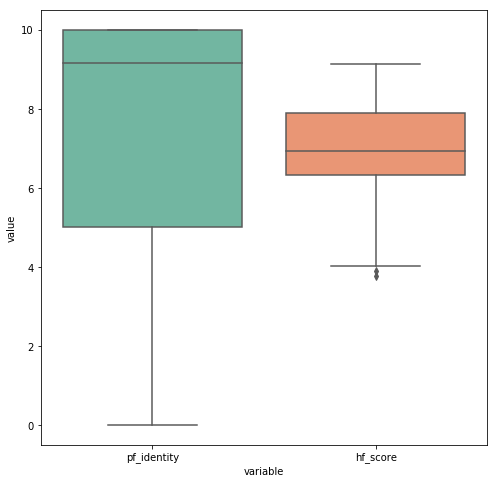

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
seaborn.boxplot(data=pandas.melt(dataset[['pf_identity','hf_score']]),
                x="variable", y="value", palette="Set2")



Notamos que *hf_score* tiene valores outliers. Para detectar si son globales o por grupo podemos mirar



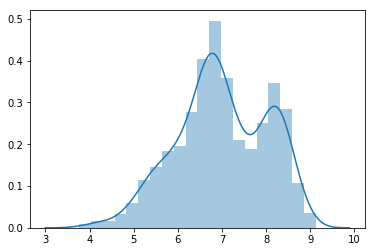

In [13]:
seaborn.distplot(dataset[['hf_score']].dropna())


Mirando el histograma que corresponde a *hf_score* vemos que hay algunos valores en el extremo izquierdo, no estan exageradamente alejados del valor medio, y ademas caen adentro del rango de la variable. Lo cual nos dice que los outliers encontrados son de grupo.

## 2. Agregación de datos

1. Grafiquen la media de la variable *pf_identity* y *hf_score* a través de los años.

In [14]:
from IPython.display import display, HTML
plt.figure(figsize=(12,4))

df = dataset[['year','pf_identity','hf_score']].dropna().groupby(['year']).mean().reset_index()
display(HTML(df.to_html()))

,year,pf_identity,hf_score
0,2008,7.517730,7.069785
1,2009,7.517730,7.075678
2,2010,7.303922,7.036396
3,2011,7.467320,7.031203
4,2012,7.467320,6.985917
5,2013,7.364650,6.983139
6,2014,7.387317,6.958734
7,2015,7.062893,6.932810
8,2016,6.976337,6.889871


<Figure size 864x288 with 0 Axes>

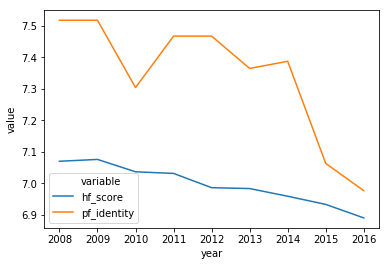

In [15]:
df=pandas.melt(df, id_vars=['year']).sort_values(['variable','value'])
seaborn.lineplot(data=df, x='year', y='value', hue='variable')

2. Realicen los mismos gráficos, pero separando por regiones (Cada variable en un gráfico distinto, sino no se ve nada). ¿La tendencia observada, es la misma que si no dividimos por regiones?

In [16]:
df_means = dataset[['year', 'region','pf_identity','hf_score']].dropna().groupby(['year','region']).mean().reset_index()

def group_variable_by_region(dataset,variable):
    df = pandas.melt(
        dataset[['year', 'region',variable]],
        id_vars=['year','region']
    ).sort_values(
        ['variable','value']
    )
    seaborn.lineplot(data=df, x='year', y='value', hue='region')


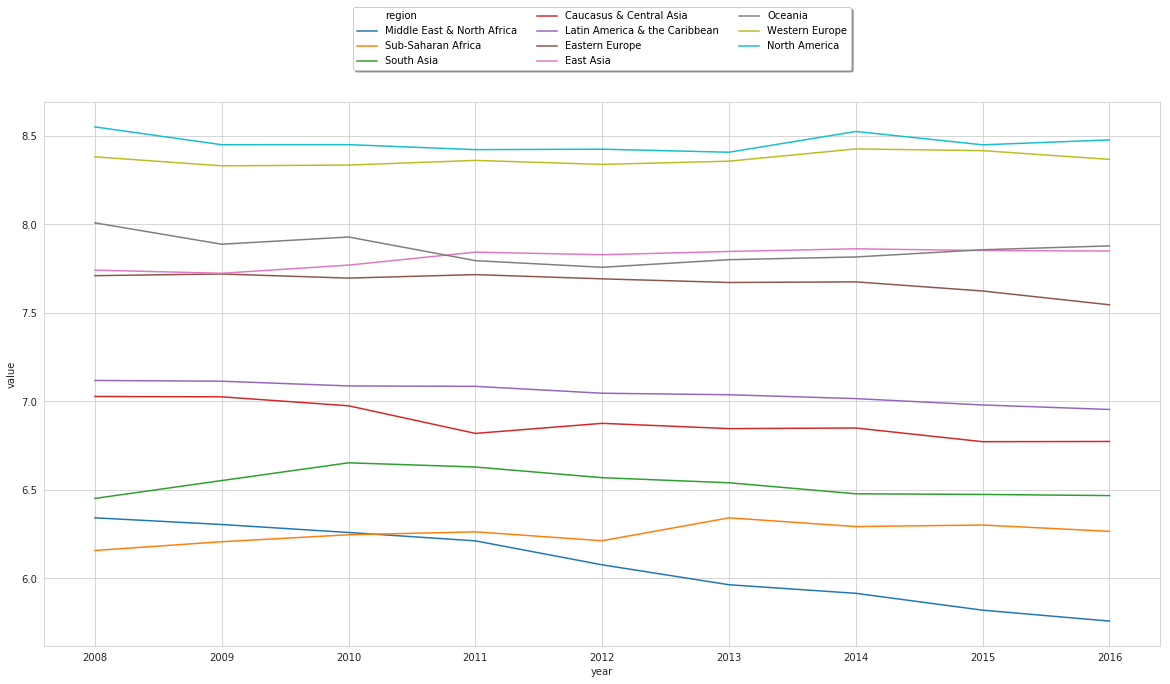

In [17]:
with seaborn.axes_style("whitegrid", {'axes.grid' : True}):
    fig, ax = plt.subplots(1,1, figsize=(20,10))

group_variable_by_region(df_means,'hf_score')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)


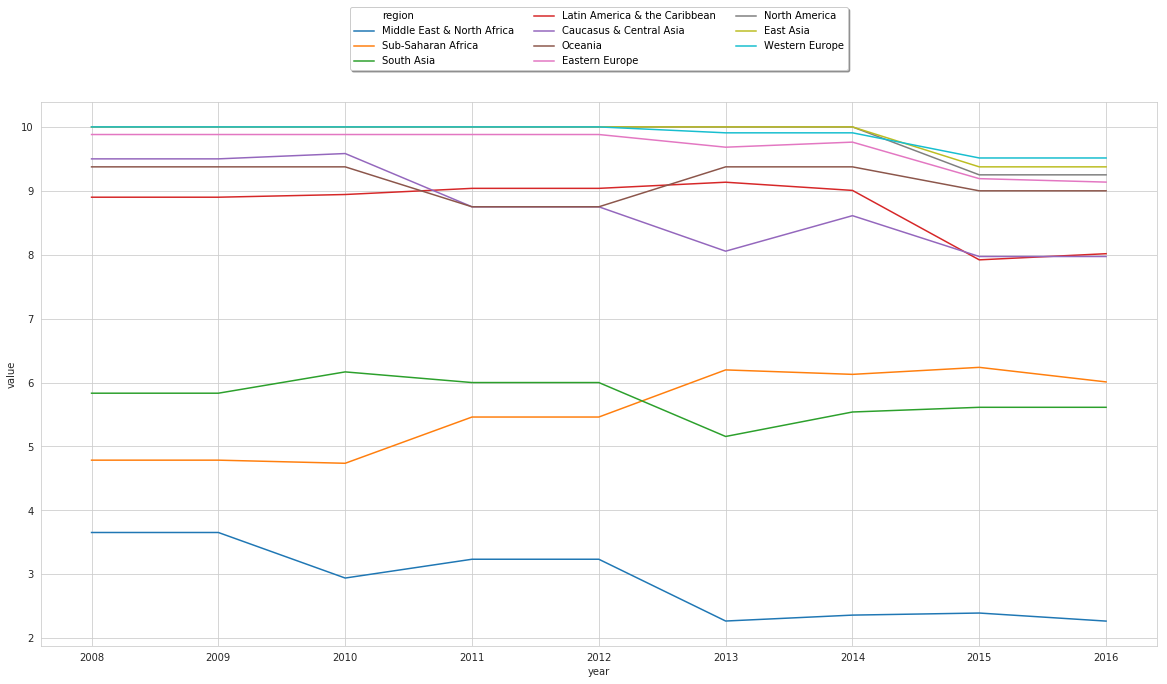

In [18]:
with seaborn.axes_style("whitegrid", {'axes.grid' : True}):
    fig, ax = plt.subplots(1,1, figsize=(20,10))

group_variable_by_region(df_means,'pf_identity')
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05),
      ncol=3, fancybox=True, shadow=True)


3. Si lo consideran necesario, grafiquen algunos países de Latinoamerica para tratar de explicar la tendencia de la variable *pf_identity* en la región. ¿Cómo seleccionarion los países relevantes a esa tendencia?

Hint: hay un gráfico de seaborn que hace todo por vos!

Sólo por curiosidad, graficar la tendencia de *hf_score* y *ef_score* a través de los años. ¿Tienen alguna hipótesis para este comportamiento?

,year,hf_score,ef_score
0,2008,7.069785,6.742270
1,2009,7.075678,6.759504
2,2010,7.036396,6.766013
3,2011,7.031203,6.803399
4,2012,6.985917,6.783922
5,2013,6.983139,6.792420
6,2014,6.958734,6.818239
7,2015,6.932810,6.801572
8,2016,6.889871,6.795062


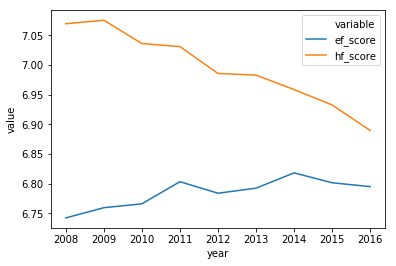

In [19]:
df = dataset[['year','hf_score','ef_score']].dropna().groupby(['year']).mean().reset_index()
display(HTML(df.to_html()))
df=pandas.melt(df, id_vars=['year']).sort_values(['variable','value'])

#barras vs lineas
seaborn.lineplot(data=df, x='year', y='value', hue='variable')

*Economic Freedon Score* se utiliza para calcular *Human Freedom Score*, y tiene mucho peso, pondera casi la mitad del valor segun *https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2018-revised.pdf* (pagina 16). En base al informe, las actividades económicas en nuestra vida son muy comunes, por lo tanto mientras menos restricciones se tengan sobre esatas actividades, mayor será la independencia y la capasidad de elección por parte de una persona. (TODO: ¿Pero poque a lo largo de los años?)

## 2. Distribuciones
  1. Graficar en un mismo histograma la distribución de la variable *pf_identity* en global, y en Latinoamérica y el caribe. Repetir para la variable *hf_score*. ¿Visualmente, a qué tipo de distribución corresponde cada variable? ¿Es correcto utilizar todos los registros para esas zonas en estos gráficos?


##### *pf_identity* para Latinoamerica vs Global

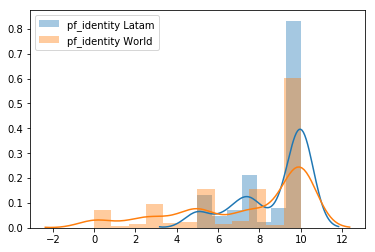

In [20]:
df1 = dataset[filter_latam]
seaborn.distplot(df1[['pf_identity']].dropna(),label="pf_identity Latam")
seaborn.distplot(dataset[["pf_identity"]].dropna(),label="pf_identity World")
plt.legend()

Cuando estábamos observando *outliers* en el diagrama boxplot, podíamos observar que la variable *pf_identity* practicamente tenia valores entre 8 y 10 (el máximo del su rago). Ahora podemos ver que estas dos distrituciones concentran moda en 10, ademas de tener una clara asimetria negativa. Visualmente vemos que ambas se comportan como una distribucion normal con un muy notorio sesgo negativo (Left-skewed distributions).

Agregamos los diagramas boxplot para ambos casos

##### *hf_score* para Latinoamerica vs Global

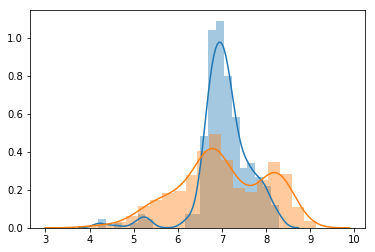

In [21]:
ds = dataset[filter_latam]

seaborn.distplot(ds[['hf_score']].dropna())
seaborn.distplot(dataset[['hf_score']].dropna())

Para el caso de hf_score, notamos que la distribución tiene un comportamiento Multimodal para le caso Global y leptokurtica para Latinoamerica y Caribe. Vamos a extender un poco el análisis para determinar si podemos hacer alguna observacion mas específica sobre el caso *hf_score* en Global.
- Mirando un poco los diagramas de boxplot, podemos observar el comportamiento por region de la variable hf_score


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

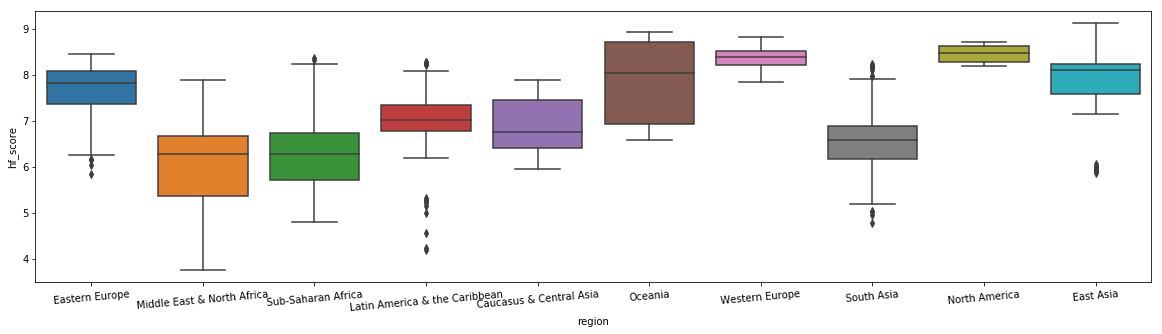

In [22]:
#Algunas configuraciones para el grafico
plt.subplots(1,1, figsize=(20,5))

#solo hf_score y region, sin NaN
region = dataset[['region', "year", 'hf_score']].dropna()

#Acomodamos los datos para que podamos a
#df_long = pandas.melt(region, "year",var_name="hf_score" , value_name="score")

g = seaborn.boxplot("region", y="hf_score", data=region)
plt.xticks(rotation=5)


Podemos observar que para las regiones *Estearn Europe* *Western Europe* *North America*, los datos estan muy cerca de su media, con muy poca dispersion.

Sepáramos estas regiones y las comparamos con el resto, superponiendo los histogramas.

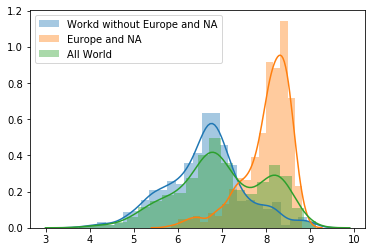

In [23]:
eastern_europe = "Eastern Europe"
western_europe = "Western Europe"
north_america = "North America"

filter_ee = dataset["region"] == eastern_europe
filter_na = dataset["region"] == north_america
filter_western_europe = dataset["region"] == western_europe

no_europe_and_na = dataset[ ~( filter_ee | filter_western_europe | filter_na ) ]
europe_and_na = dataset[ ( filter_ee | filter_western_europe | filter_na ) ]

#juntamos los histogramas con la idea de poder ver si hay alguna relacion.
seaborn.distplot(no_europe_and_na[['hf_score']].dropna(),  label='Workd without Europe and NA')
seaborn.distplot(europe_and_na[['hf_score']].dropna(),  label='Europe and NA')
seaborn.distplot(dataset[['hf_score']].dropna(),  label='All World')
plt.legend()

Para Global, la distribucion es multimodal y por lo observado podemos suponer es es una mixtura entre dos distribuciones normales.

El caos de la variable *hf_score* si bien comparado con *pf_identity* la asimetria no es tan marcada, se puede observar a simple vista, que America Latina y Caribe tiene una asimetria negativa y mayor cutosis. Para este caso ambas distribuciones son semejantes a una normal. 

  2. Realizar una prueba de Kolmogorov-Smirnof para comprobar analíticamente si estas variables responden la distribución propuesta en el ejercicio anterior. Hint: podés usar https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html, pero hay que tener en cuenta que si la distribución es "norm", entonces va a comparar los datos con una distribución normal con media 0 y desviación estándar 1. Se puede utilizar la distribución sobre todos los datos o sólo sobre Latinoamérica.

In [31]:
def test_hipotesis(D, p, alpha, label):
    validate = (p < alpha)
    print("Para " + label + ":")
    if validate:
        print ("Hipotesis nula puede ser rechazada")
    else:
        print ("Hipotesis nula NO puede ser rechazada")
    print(D, p)
    return validate

#estandarizar nuestras distribuciones

alpha=0.05

hf_score_latam = dataset[filter_latam]['hf_score'].dropna()
hf_score_world = dataset[['hf_score']].dropna()
pf_identity_latam = dataset[filter_latam]['pf_identity'].dropna()
pf_identity_world = dataset[['pf_identity']].dropna()

D, p = stats.kstest(stats.zscore(hf_score_latam),'norm')
test_hipotesis(D, p, alpha, 'hf_score_latam')
D, p = stats.kstest(stats.zscore(hf_score_world),'norm')
test_hipotesis(D, p, alpha, 'hf_score_world')
D, p = stats.kstest(stats.zscore(pf_identity_latam),'norm')
test_hipotesis(D, p, alpha, 'pf_identity_latam')
D, p = stats.kstest(stats.zscore(pf_identity_world),'norm')
test_hipotesis(D, p, alpha, 'pf_identity_world')


stats.kstest(hf_score_latam, 'norm', args=(hf_score_latam.mean(),hf_score_latam.std()))


Para hf_score_latam:
Hipotesis nula puede ser rechazada
0.15003247403280606 5.043599840583937e-05
Para hf_score_world:
Hipotesis nula puede ser rechazada
0.9991767662712046 0.0
Para pf_identity_latam:
Hipotesis nula puede ser rechazada
0.3513672528496658 4.08023938470139e-26
Para pf_identity_world:
Hipotesis nula puede ser rechazada
0.9898881929872717 0.0


KstestResult(statistic=0.1504746027707088, pvalue=4.737935317381503e-05)

  3. Realizar un gráfico QQ de las mismas distribuciones. Se puede utilizar a,bas distribuciones sobre todos los datos o sólo sobre Latinoamérica, pero no cruzadas.

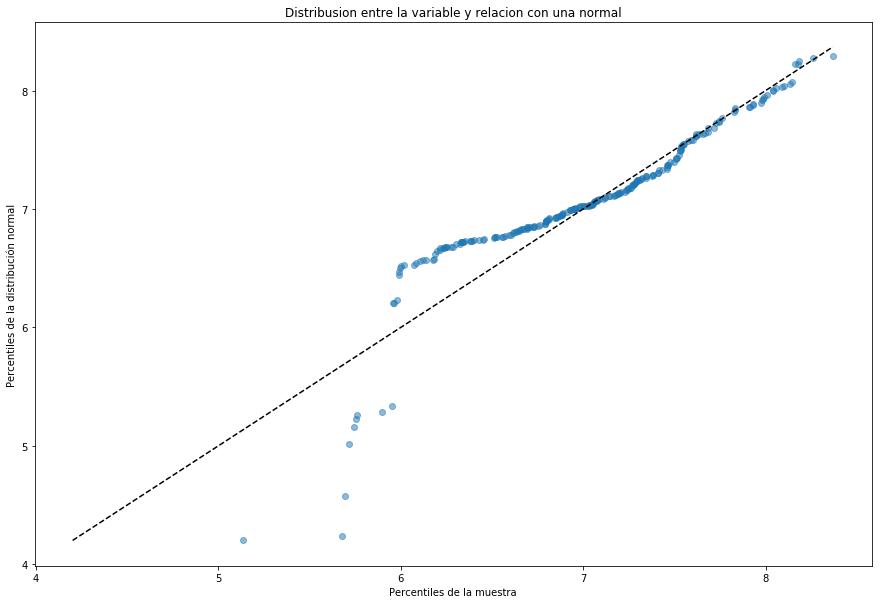

In [50]:
def normal_with_same_params(dataset):
    return numpy.random.normal(dataset.mean(), dataset.std(), dataset.shape[0])

def qqplot(dataset_x, dataset_y):
    percs= numpy.linspace(0,100,dataset_x.shape[0] )
    qn_a = numpy.percentile(dataset_x, percs)
    qn_b = numpy.percentile(dataset_y, percs)
    
    line_start = numpy.min((qn_a.min(), qn_b.min()))
    line_end = numpy.max((qn_a.max(), qn_b.max()))
    
    plt.scatter(qn_a, qn_b, alpha=0.5)

    x = numpy.linspace(line_start, line_end )
    plt.plot(x,x, color="k", ls="--")
    plt.xlabel('Percentiles de la muestra')
    plt.ylabel('Percentiles de la distribución normal')
    plt.title('Distribusion entre la variable y relacion con una normal')

#let_normal = normal_with_same_params(hf_score_latam)
#qqplot(stats.zscore(pf_identity_latam), stats.zscore(hf_score_latam), percs)
plt.figure(figsize=(15,10))
let_normal = normal_with_same_params(hf_score_latam)
qqplot(let_normal, hf_score_latam)

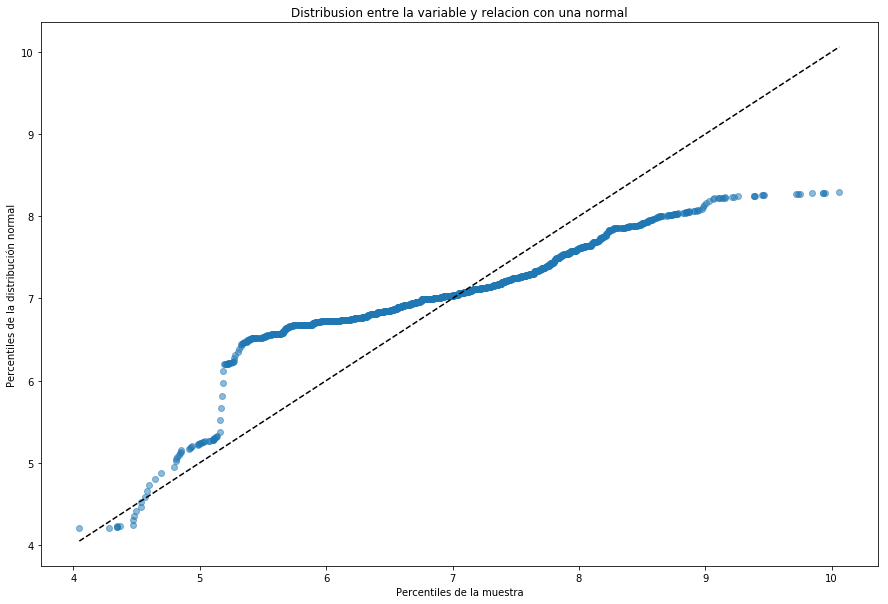

In [51]:
plt.figure(figsize=(15,10))
let_normal = normal_with_same_params(hf_score_world)
qqplot(let_normal, hf_score_latam)

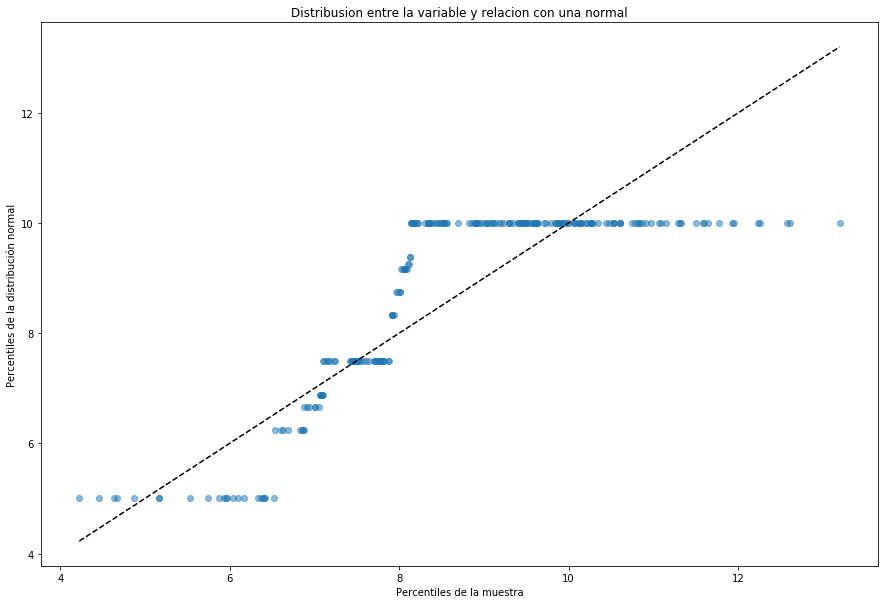

In [52]:
plt.figure(figsize=(15,10))
let_normal = normal_with_same_params(pf_identity_latam)
qqplot(let_normal, pf_identity_latam)


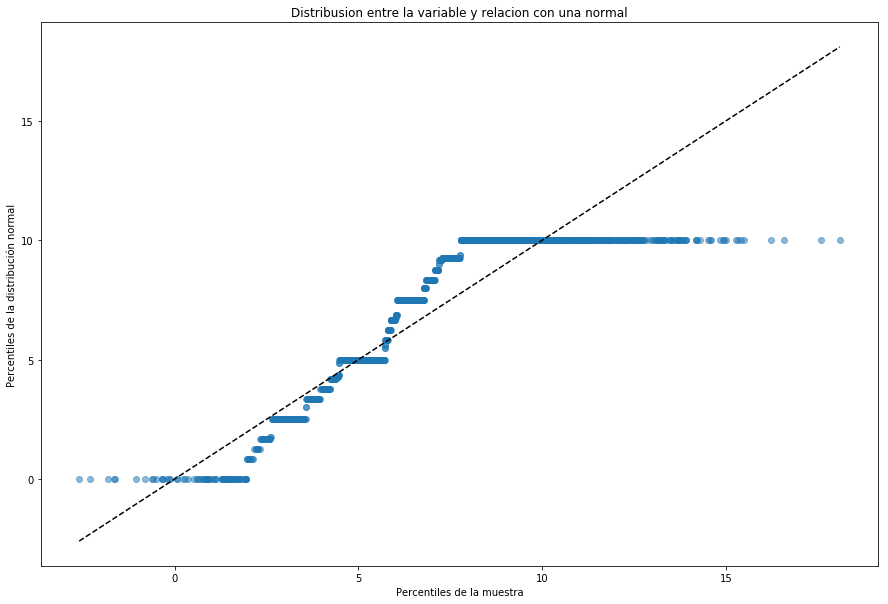

In [53]:
plt.figure(figsize=(15,10))
let_normal = normal_with_same_params(pf_identity_world)
qqplot(let_normal, pf_identity_world)


  4. Medir la asimetría (skew) y curtosis de las mismas distribuciones con las que realizó el gráfico anterior. ¿Cómo se relacionan estos estadísticos con la forma del gráfico QQ obtenido previamente? ¿El gráfico QQ provee más información que no esté presente en estos estadísticos?

In [36]:
hf_score_latam = dataset[filter_latam]['hf_score'].dropna()
hf_score_world = dataset[['hf_score']].dropna()
pf_identity_latam = dataset[filter_latam]['pf_identity'].dropna()
pf_identity_world = dataset[['pf_identity']].dropna()

def print_values(dataset, label):
    print(" Valor de asimetria para " + label)
    print( stats.skew (dataset))
    print(" Valor de lurtosis para " + label)
    print(stats.kurtosis(dataset))

print_values(hf_score_latam, 'hf_score latinoamerica y caribe')
print_values(hf_score_world, 'hf_scrore resto del mundo')
print_values(pf_identity_latam, 'pf_identity')
print_values(pf_identity_world, 'pf_identity')


 Valor de asimetria para hf_score latinoamerica y caribe
-1.442092151332142
 Valor de lurtosis para hf_score latinoamerica y caribe
5.340188962725749
 Valor de asimetria para hf_scrore resto del mundo
[-0.2120519]
 Valor de lurtosis para hf_scrore resto del mundo
[-0.51019043]
 Valor de asimetria para pf_identity
-1.0478440216224703
 Valor de lurtosis para pf_identity
-0.2953048553672586
 Valor de asimetria para pf_identity
[-0.91217805]
 Valor de lurtosis para pf_identity
[-0.41483222]


## 3. Correlaciones

En este ejercicio queremos responder a las preguntas

* Las libertades sociales y económicas, ¿van siempre de la mano?
* ¿Cómo se relacionan ambas con las libertades individuales y respectivas a las relaciones personales?

Para ello, analizaremos las correlaciones entre las variables pf_identity, hf_score y ef_score. 

Como pf_indentity contribuye al cálculo de hf_score y ef_score, esperamos hallar algún grado de correlación. Sin embargo, queremos medir qué tanta correlación. 

1. ¿Qué conclusiones puede sacar de un gráfico pairplot de estas tres variables? ¿Es adecuado para los valores de pf_identity? ¿Por qué?
2. Graficar la correlación entre pf_identity y hf_score; y entre pf_identity y ef_score. Analizar el resultado, ¿se pueden sacar conclusiones? Tengan en cuenta que como pf_identity es el resultado de un promedio, sólo toma algunos valores. Es, en efecto, discreta.
3. Calcular algún coeficiente de correlación adecuado entre los dos pares de variables, dependiendo de la cantidad de datos, el tipo de datos y la distribución de los mismo. Algunas opciones son: coeficiente de pearson, coeficiente de spearman, coeficientes de tau y de kendall. Interpretar los resultados y justificar si las variables están correlacionadas o no. 
4. [Opcional] Analizar la correlación entre la region y el hf_score (y/o el ef_score); y entre la region y el pf_identity. Considerar que como la variable *region* es ordinal, debe utilizarse algún tipo de test. Explicar cuáles son los requisitos necesarios para la aplicación de ese test. (Si no se cumplieran, se pueden agregar algunos datos para generar más registros)
